In [1]:
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import requests
from torchvision import transforms, models
#Requests is an Apache2 Licensed HTTP library, 
#written in Python. It is designed to be used by humans
# to interact with the language. This means you don't have to manually add query strings to URLs"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


![picture](https://drive.google.com/uc?id=19uJQB8NmD0UzCUzKEJOTgLdK2ARxbP8I)

![picture](https://drive.google.com/uc?id=1mhZyDh_gHIUb-m5_ULa1Dj7fshOFPT_U)

In [3]:
# get the "fatures" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features
# freeze all VGG parameters since we are only optimizing the target image
for param in vgg.parameters():
  param.requires_grad_(False) 

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [5]:
def load_image(img_path, max_size=400, shape=None):
  
  if "http" in img_path:
    response = requests.get(img_path)
    image = Image.open(BytesIO(response.content)).convert('RGB')
  else:
    image = Image.open(img_path).convert('RGB')

  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape is not None:
    size = shape

  in_transform = transforms.Compose([transforms.Resize(size),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])          
  image = in_transform(image)[:3,:,:].unsqueeze(0)

  return image

In [9]:
path = 'drive/My Drive/E0-270 Term Paper/Images/'
#content = load_image('https://drive.google.com/uc?id=1mhZyDh_gHIUb-m5_ULa1Dj7fshOFPT_U').to(device)
#style = load_image('https://drive.google.com/uc?id=19uJQB8NmD0UzCUzKEJOTgLdK2ARxbP8I',shape=content.shape[-2:]).to(device)
content = load_image(path + 'newtown.jpg').to(device)
style = load_image(path + 'starry_night.jpg',shape=content.shape[-2:]).to(device)


In [10]:
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  iamge = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  return image

[]

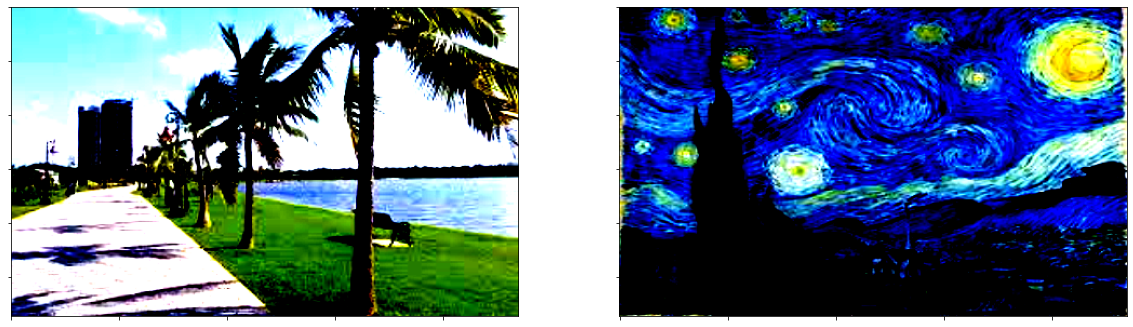

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax2.imshow(im_convert(style))
ax2.set_yticklabels([])
ax2.set_xticklabels([])

###VGG19 Layers
To get the content and style representations of an image, we have to pass an image forward through the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

In [12]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [13]:
def get_features(image, model, layers=None):
  if layers is None:
    layers = {'0': 'conv1_1' ,
              '5' : 'conv2_1' ,
              '10' : 'conv3_1' ,
              '19' : 'conv4_1' ,
              '21': 'conv4_2' , 
              '28' : 'conv5_1'}

  features = {}
  x = image
  """ model._modules is a dictionary holding each module in te model """
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x 

  return features             

###Gram Matrix
The output of every convolutional layer is a Tensor with dimensions associated with the batch_size, a depth, d and some height and width (h, w). The Gram matrix of a convolutional layer can be calculated as follows:

Get the depth, height, and width of a tensor using batch_size, d, h, w = tensor.size
Reshape that tensor so that the spatial dimensions are flattened
Calculate the gram matrix by multiplying the reshaped tensor by it's transpose
Note: You can multiply two matrices using torch.mm(matrix1, matrix2)

In [14]:
def gram_matrix(tensor):
  _,d,h,w = tensor.size()
  tensor = tensor.view(d,h*w)
  gram = torch.mm(tensor, tensor.t())

  return gram

##Putting it all Together
Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation

In [15]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
"""create a third "target" image and prep it for change
 it is a good idea to start off with the target as a copy of our *content* image
 then iteratively change its style"""
target = content.clone().requires_grad_(True).to(device)


In [16]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation, change each style weight to 0.2
style_weights = {'conv1_1': 1.0,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

# change it to 10^-1, 10^-2, 10^-3, 10^-4
content_weight = 100 # alpha
style_weight = 1  # beta

Total loss:  5.319210529327393


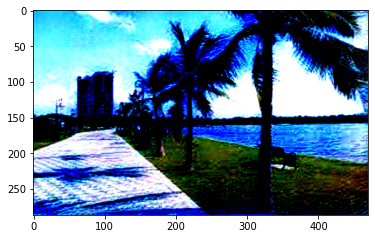

Total loss:  5.035086631774902


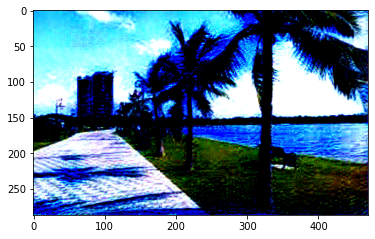

Total loss:  4.781933307647705


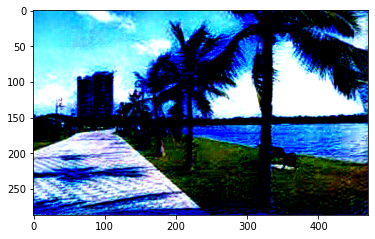

Total loss:  4.576611518859863


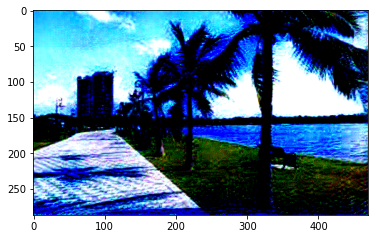

Total loss:  4.389972686767578


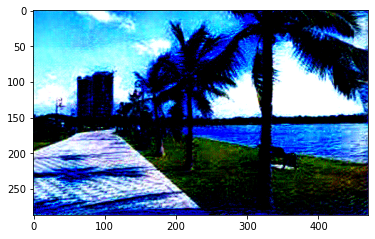

In [18]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters, change optimizer from Adam to LBFGS
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()    #closure was not here for Adam

    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show() 

[]

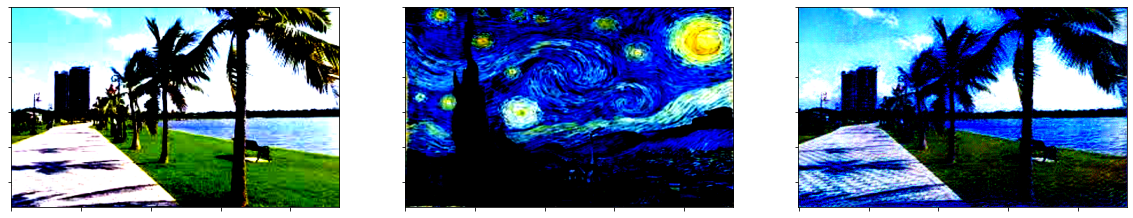

In [19]:
# display content and final, target image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax2.imshow(im_convert(style))
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax3.imshow(im_convert(target))
ax3.set_yticklabels([])
ax3.set_xticklabels([])